In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/COVID-19_Radiography_Dataset"

Mounted at /content/gdrive
 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia'
 Normal			     'Viral Pneumonia.metadata.xlsx'


In [ ]:
#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---
# taken from https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP_%28z%2Bquantize_method_with_augmentations%2C_user_friendly_interface%29.ipynb#scrollTo=XHyPd4oxVp_l stops colab disconnecting
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
IPython.display.Javascript(js_code)     

<IPython.core.display.Javascript object>

In [ ]:
# import packages

import tensorflow as tf
from keras import datasets, layers, models
import keras as keras
import numpy as np
import pandas as pd
import matplotlib as plt
import os
import graphviz
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import load_model


# for reproducibility - ref https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
np.random.seed(9)
tf.keras.utils.set_random_seed(10)

chest_xray_dataset = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/images")
chest_xray_dataset_annotations = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/metadata.csv")
radiography_dataset = os.path.abspath("/content/gdrive/My Drive/COVID-19_Radiography_Dataset/")
xray_covid19_dataset = os.path.abspath("/content/gdrive/My Drive/xray_dataset_covid19/")


Found 30306 files belonging to 3 classes.
Using 21215 files for training.
Found 30306 files belonging to 3 classes.
Using 9091 files for validation.


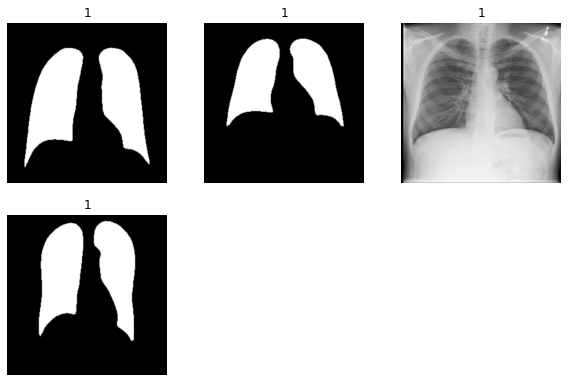

In [ ]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (299, 299)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(radiography_dataset, validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(radiography_dataset, validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

# create test set - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
# 20 % now used for test and 10% used for validation
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

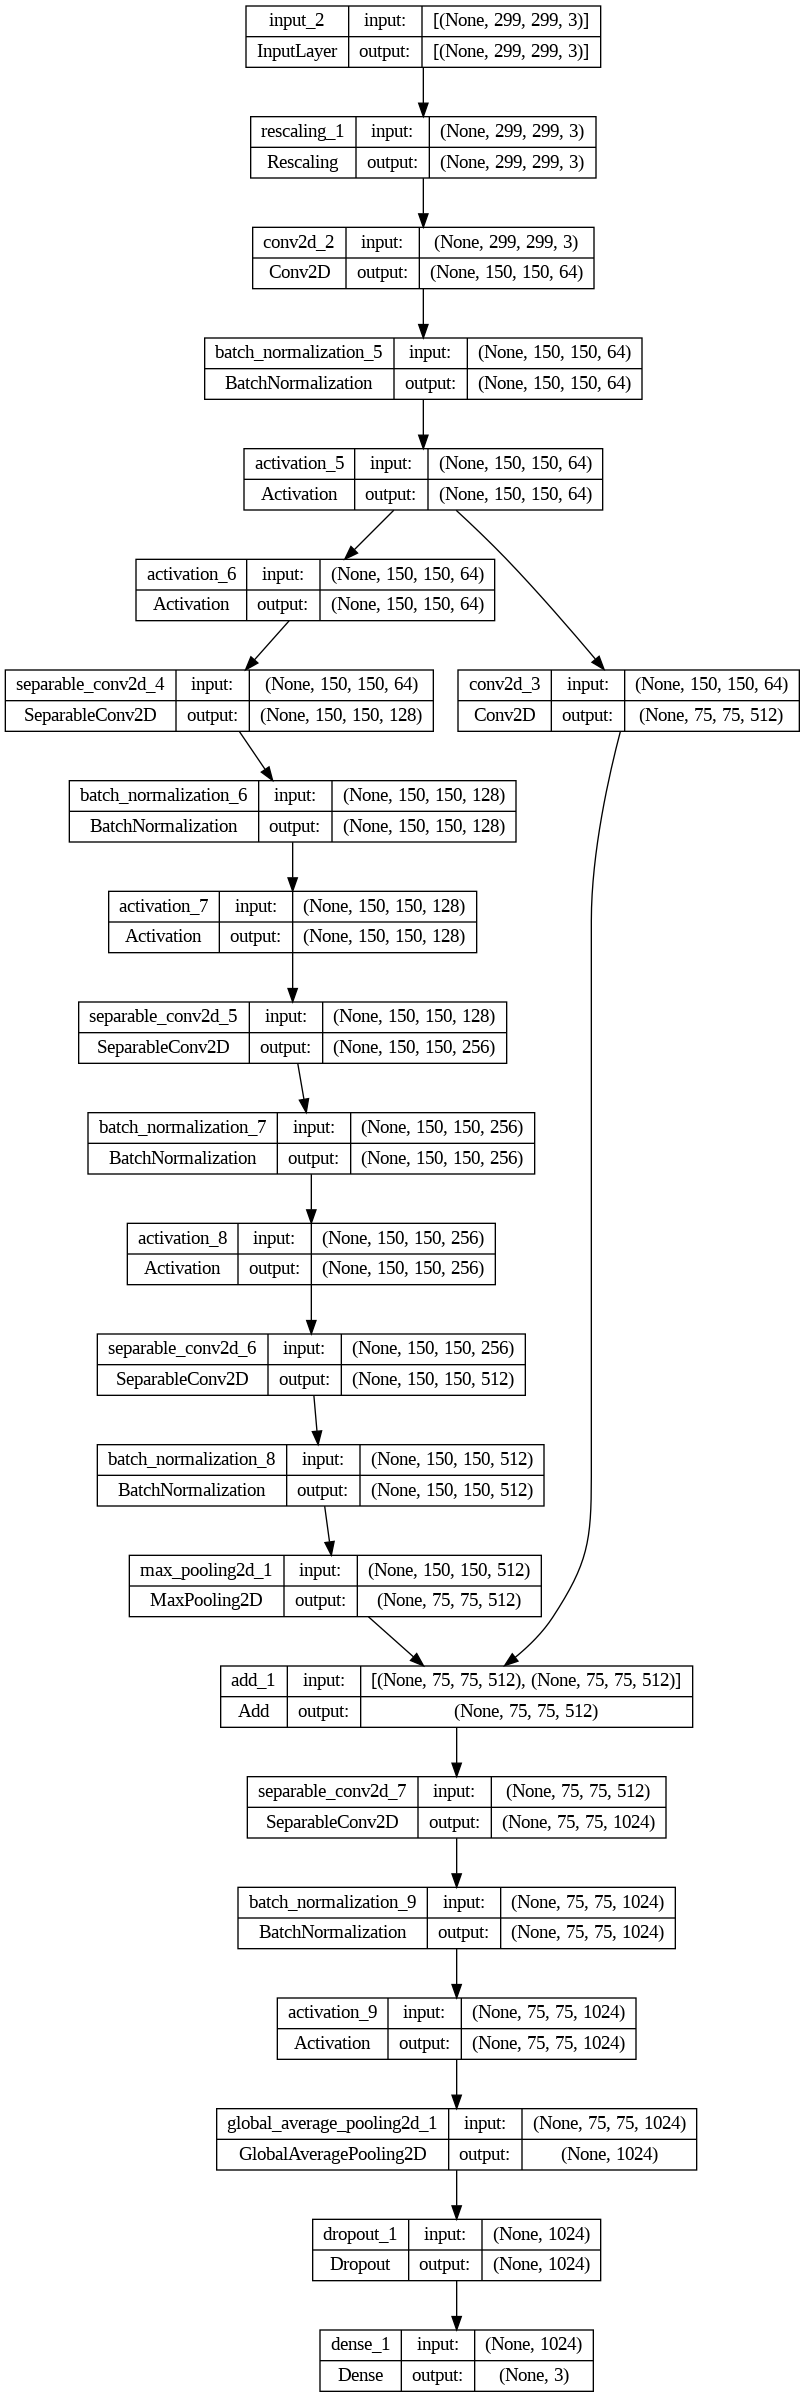

In [ ]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(512, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = 3

    x = layers.Dropout(0)(x)
    outputs = layers.Dense(3, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 299, 299, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 150, 150, 64  1792        ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

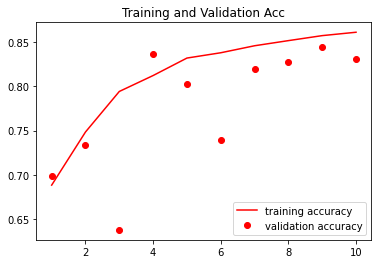

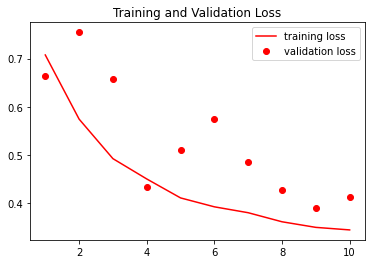

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/radiography_model.h5')
score = model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Transfer Learning Model Baseline

83683744/83683744 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,386,795
Trainable params: 21,332,267
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10
663/663 [==============================] - 97s 137ms/step - loss: 0.3436 - acc: 0.8588 - val_loss: 0.3537 - val_acc: 0.8675
Epoch 2/10
663/663 [==============================] - 88s 133ms/step - loss: 0.2542 - acc: 0.8979 - val

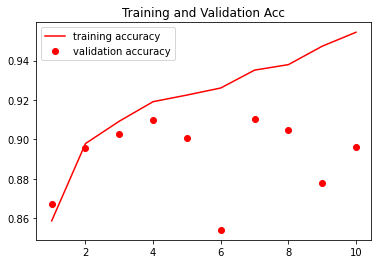

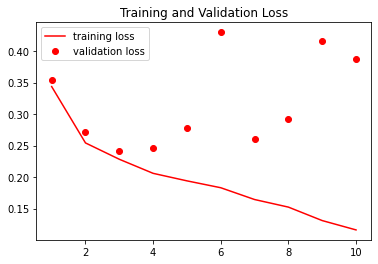

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
Xception_model = Sequential()
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling='avg',
    classes=3,
    classifier_activation="softmax",
)
Xception_model.add(model)
Xception_model.add(Dense(256,activation='relu'))
Xception_model.add(Dense(3,activation='softmax'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
Xception_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
Xception_model.summary()
history = Xception_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
Xception_model.save('content/gdrive/My Drive/CNN_Models_Baseline/xception_radiography_model.h5')
score = Xception_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

94668760/94668760 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 24,090,115
Trainable params: 24,044,675
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
663/663 [==============================] - 72s 99ms/step - loss: 0.4954 - acc: 0.7915 - val_loss: 1.1678 - val_acc: 0.6559
Epoch 2/10
663/663 [==============================] - 63s 95ms/step - loss: 0.3349 - acc: 0.8650 - val

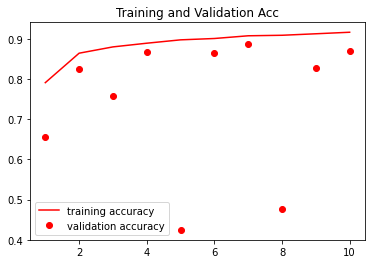

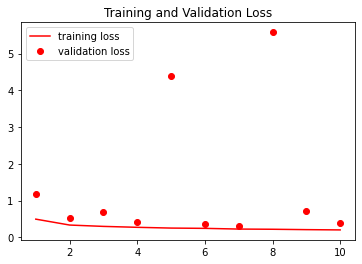

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
ResnetModel50V2_model = Sequential()
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling='avg',
    classes=3,
    classifier_activation="softmax",
)
ResnetModel50V2_model.add(model)
ResnetModel50V2_model.add(Dense(256,activation='relu'))
ResnetModel50V2_model.add(Dense(3,activation='softmax'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
ResnetModel50V2_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
ResnetModel50V2_model.summary()
history = ResnetModel50V2_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
ResnetModel50V2_model.save('content/gdrive/My Drive/CNN_Models_Baseline/resnetmodel50v2_radiography_model.h5')
score = ResnetModel50V2_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

82420632/82420632 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 20,660,067
Trainable params: 20,506,195
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/10
663/663 [==============================] - 148s 192ms/step - loss: 0.3394 - acc: 0.8616 - val_loss: 0.3091 - val_acc: 0.8864
Epoch 2/10
663/663 [=============

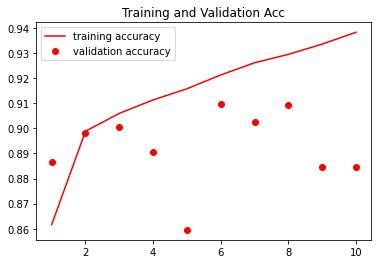

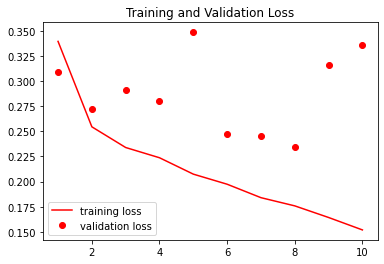

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
EfficientNetV2S_model	= Sequential()
model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling='avg',
    classes=3,
    classifier_activation="softmax",
)
EfficientNetV2S_model.add(model)
EfficientNetV2S_model.add(Dense(256,activation='relu'))
EfficientNetV2S_model.add(Dense(3,activation='softmax'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
EfficientNetV2S_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
EfficientNetV2S_model.summary()
history = EfficientNetV2S_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
EfficientNetV2S_model.save('content/gdrive/My Drive/CNN_Models_Baseline/efficient_net_V2S_radiography_model.h5')
score = EfficientNetV2S_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Augmented Models

Found 60933 files belonging to 3 classes.
Using 42654 files for training.
Found 60933 files belonging to 3 classes.
Using 18279 files for validation.


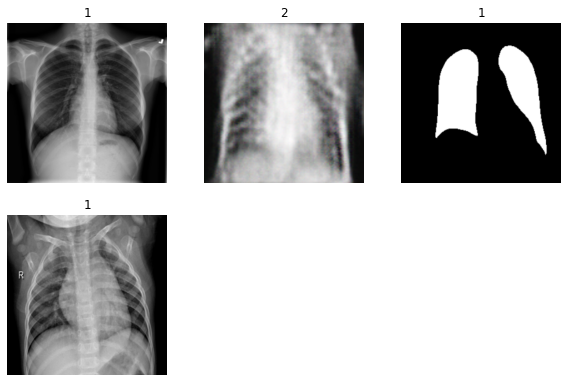

In [ ]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (299, 299)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(radiography_dataset, validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(radiography_dataset, validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

# create test set - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
# 20 % now used for test and 10% used for validation
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Baseline Model DCGAN


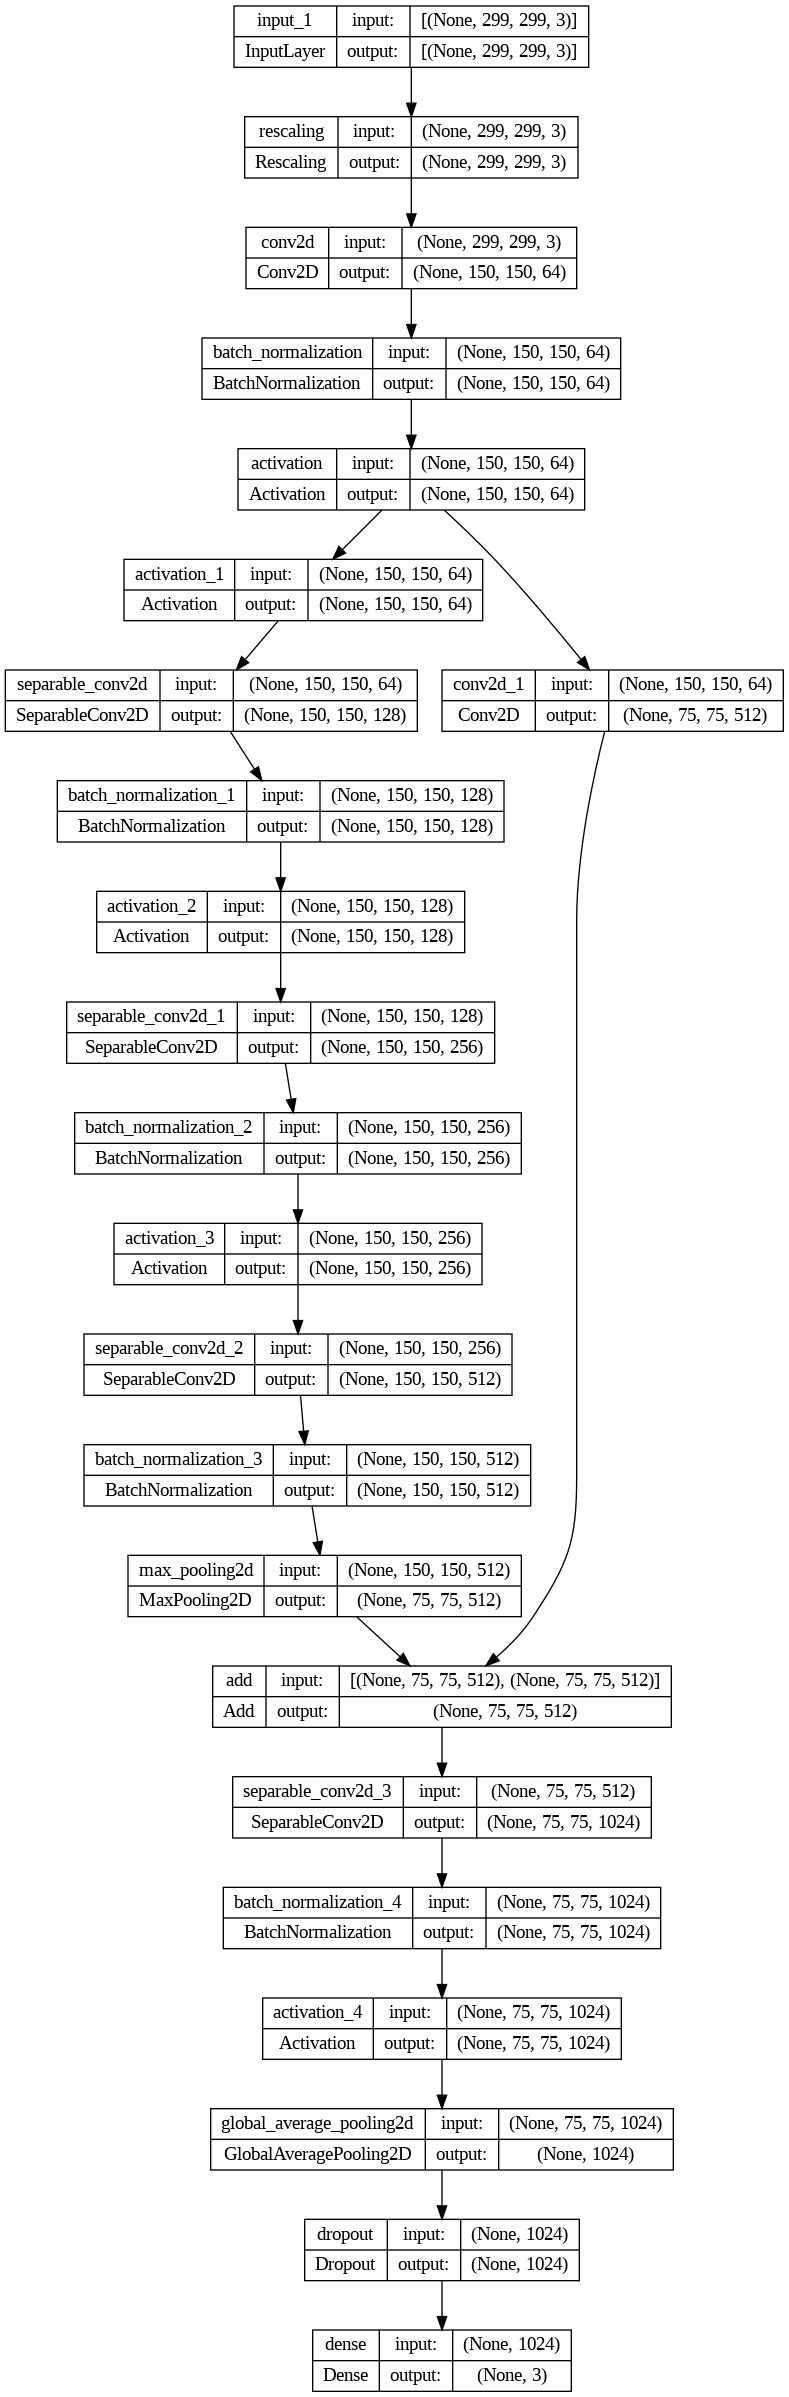

In [ ]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(512, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = 3

    x = layers.Dropout(0)(x)
    outputs = layers.Dense(3, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 299, 299, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 64  1792        ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

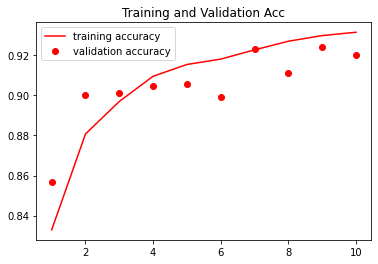

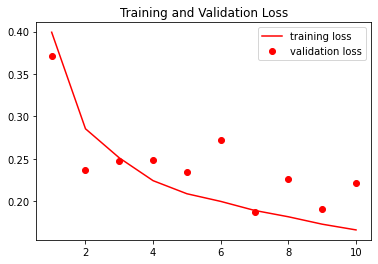

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/radiography_augmented_dcgan_model.h5')
score = model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Augmented Transfer Learning Models DCGAN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_1 (Dense)             (None, 256)               524544    
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,386,795
Trainable params: 21,332,267
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10
1333/1333 [==============================] - 183s 133ms/step - loss: 0.2134 - acc: 0.9171 - val_loss: 0.1294 - val_acc: 0.9484
Epoch 2/10
1333/1333 [==============================] - 175s 131ms/step - loss: 0.1415 - acc: 0.9438 - val_loss: 0.1638 - val_acc: 0.9353
Epoch 3/10
1333/1333 [=====

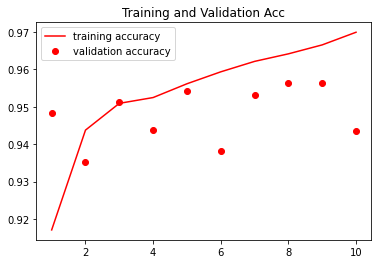

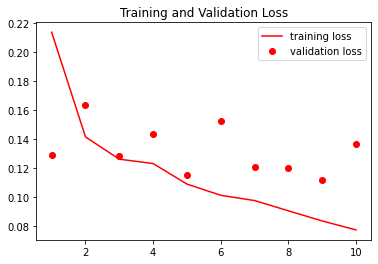

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
Xception_model = Sequential()
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling='avg',
    classes=3,
    classifier_activation="softmax",
)
Xception_model.add(model)
Xception_model.add(Dense(256,activation='relu'))
Xception_model.add(Dense(3,activation='softmax'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
Xception_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
Xception_model.summary()
history = Xception_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
Xception_model.save('content/gdrive/My Drive/CNN_Models_Baseline/xception_radiography_augmented_dcgan_model.h5')
score = Xception_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dense_4 (Dense)             (None, 3)                 771       
                                                                 
Total params: 24,090,115
Trainable params: 24,044,675
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
1333/1333 [==============================] - 133s 94ms/step - loss: 0.2826 - acc: 0.8851 - val_loss: 0.4369 - val_acc: 0.7991
Epoch 2/10
1333/1333 [==============================] - 123s 92ms/step - loss: 0.1885 - acc: 0.9229 - val_loss: 0.2410 - val_acc: 0.9095
Epoch 3/10
1333/1333 [=====

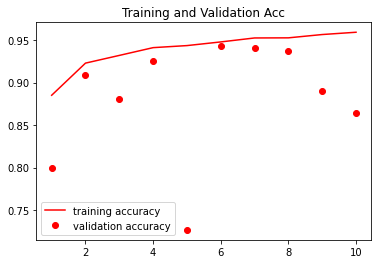

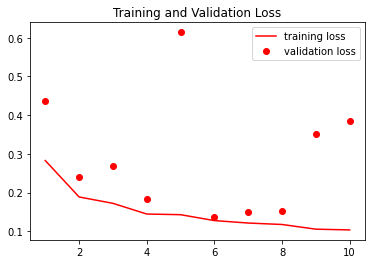

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
ResnetModel50V2_model = Sequential()
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling='avg',
    classes=3,
    classifier_activation="softmax",
)
ResnetModel50V2_model.add(model)
ResnetModel50V2_model.add(Dense(256,activation='relu'))
ResnetModel50V2_model.add(Dense(3,activation='softmax'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
ResnetModel50V2_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
ResnetModel50V2_model.summary()
history = ResnetModel50V2_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
ResnetModel50V2_model.save('content/gdrive/My Drive/CNN_Models_Baseline/resnetmodel50v2_radiography_augmented_dcgan_model.h5')
score = ResnetModel50V2_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 256)               327936    
                                                                 
 dense_6 (Dense)             (None, 3)                 771       
                                                                 
Total params: 20,660,067
Trainable params: 20,506,195
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/10
1333/1333 [==============================] - 269s 187ms/step - loss: 0.1942 - acc: 0.9225 - val_loss: 0.1204 - val_acc: 0.9512
Epoch 2/10
1333/1333 [==============================] - 245s 184ms/step - loss: 0.1458 - acc: 0.

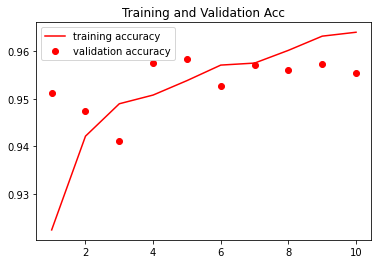

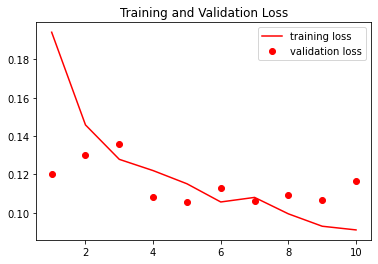

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
EfficientNetV2S_model	= Sequential()
model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling='avg',
    classes=3,
    classifier_activation="softmax",
)
EfficientNetV2S_model.add(model)
EfficientNetV2S_model.add(Dense(256,activation='relu'))
EfficientNetV2S_model.add(Dense(3,activation='softmax'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
EfficientNetV2S_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
EfficientNetV2S_model.summary()
history = EfficientNetV2S_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
EfficientNetV2S_model.save('content/gdrive/My Drive/CNN_Models_Baseline/efficient_net_V2S_radiography_augmented_dcgan_model.h5')
score = EfficientNetV2S_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show() 

### Testing the augmented models on original dataset

Found 30306 files belonging to 3 classes.
Using 21215 files for training.
Found 30306 files belonging to 3 classes.
Using 9091 files for validation.


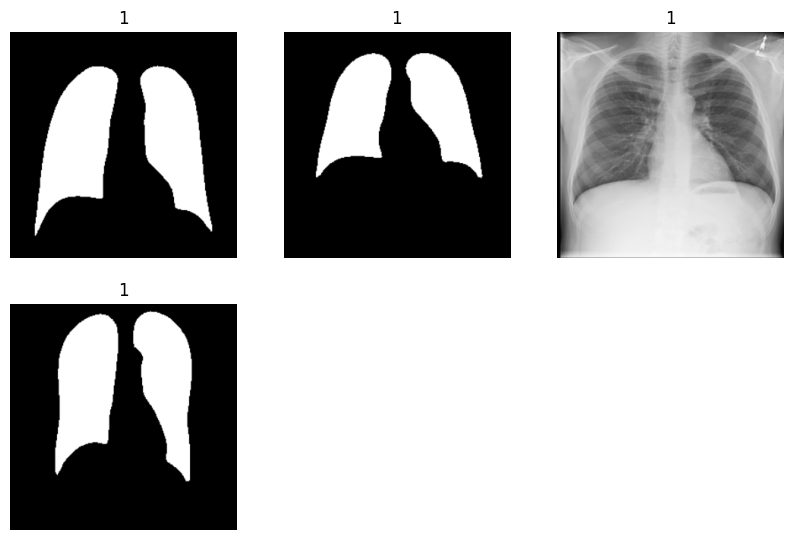

In [ ]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (299, 299)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(radiography_dataset, validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(radiography_dataset, validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

# create test set - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
# 20 % now used for test and 10% used for validation
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
test_model = load_model('/content/gdrive/My Drive/CNNFinalModelsMasters/CNNModels/Augmented Models/Radiography/radiography_augmented_dcgan_model.h5')
test_model.evaluate(test_ds)

190/190 [==============================] - 441s 2s/step - loss: 0.3814 - acc: 0.8574


[0.3814336359500885, 0.8574013113975525]

In [ ]:
xception_test_model = load_model('/content/gdrive/My Drive/CNNFinalModelsMasters/CNNModels/Augmented Models/Radiography/xception_radiography_augmented_dcgan_model.h5')
xception_test_model.evaluate(test_ds)

190/190 [==============================] - 8s 34ms/step - loss: 0.2093 - acc: 0.9145


[0.20934967696666718, 0.9144737124443054]

In [ ]:
resnet50V2_test_model = load_model('/content/gdrive/My Drive/CNNFinalModelsMasters/CNNModels/Augmented Models/Radiography/resnetmodel50v2_radiography_augmented_dcgan_model.h5')
resnet50V2_test_model.evaluate(test_ds)

190/190 [==============================] - 7s 30ms/step - loss: 0.4465 - acc: 0.8436


[0.4465011954307556, 0.8435855507850647]

In [ ]:
efficientNetV2S_test_model = load_model('/content/gdrive/My Drive/CNNFinalModelsMasters/CNNModels/Augmented Models/Radiography/efficient_net_V2S_radiography_augmented_dcgan_model.h5')
efficientNetV2S_test_model.evaluate(test_ds)

190/190 [==============================] - 12s 46ms/step - loss: 0.1660 - acc: 0.9370


[0.16595540940761566, 0.9370065927505493]